In [1]:
import giraffe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netZooPy.panda.panda import Panda
from netZooPy.otter.otter import otter

In [2]:
motif = pd.read_csv("data/lung/raw/motif.csv", index_col = 0)
motif = motif[~motif.index.duplicated(keep='first')]
print(motif.shape)

expression = pd.read_csv("data/lung/raw/expression.csv", index_col = 0)
expression = expression[~expression.index.duplicated(keep='first')]
print(expression.shape)

ischemic_time = pd.read_csv("data/lung/raw/ischemic.csv", index_col = 0)
print(ischemic_time.shape)

PPI = pd.read_csv("data/lung/raw/PPI.csv", index_col = 0)
print(PPI.shape)

(16470, 447)
(16470, 604)
(604, 1)
(447, 447)


In [3]:
def chip_validation(R):
    chip = pd.read_csv("data/lung/raw/chip_seq.csv", index_col = 0)
    chip.sort_index(inplace=True)
    chip.sort_index(axis=1,inplace=True)

    R.sort_index(inplace=True)
    R.sort_index(axis=1,inplace=True)

    commonTFs  = chip.index[chip.index.isin(R.index)]
    commonGenes= chip.columns[chip.columns.isin(R.columns)]
    
    gt = chip.loc[commonTFs, commonGenes]
    pred = R.loc[commonTFs, commonGenes]
    return gt, pred

In [4]:
ground_truths = []
preds = []
model_names = ["PANDA", "GIRAFFE", "GIRAFFE adjusted", "OTTER", "Motif"]

In [5]:
panda_regulation = pd.read_csv("data/lung/panda_res.txt", sep = " ", index_col = 'tf')
commonTFs  = panda_regulation.columns[panda_regulation.columns.isin(PPI.columns)]
commonGenes= panda_regulation.index[panda_regulation.index.isin(expression.index)]
gt_panda, reg_panda = chip_validation(panda_regulation[commonTFs].loc[commonGenes].T)
ground_truths.append(gt_panda)
preds.append(reg_panda)

In [6]:
giraffe_regulation = giraffe.Giraffe(expression.to_numpy(), motif.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), iterations = 15, lr = 0.00001).get_regulation()
gt_giraffe, reg_giraffe = chip_validation(pd.DataFrame(np.abs(giraffe_regulation.T), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_giraffe)
preds.append(reg_giraffe)

In [7]:
giraffe_regulation = giraffe.Giraffe(expression.to_numpy(), motif.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), adjusting = ischemic_time, iterations = 15, lr = 0.00001).get_regulation()
gt_adj, reg_adj = chip_validation(pd.DataFrame(np.abs(giraffe_regulation.T), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_adj)
preds.append(reg_adj)

In [8]:
otter_regulation = otter(motif.T.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), np.corrcoef(expression.to_numpy()))
gt_otter, reg_otter = chip_validation(pd.DataFrame(np.abs(otter_regulation), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_otter)
preds.append(reg_otter)

In [9]:
gt_motif, reg_motif = chip_validation(motif.T)
ground_truths.append(gt_motif)
preds.append(reg_motif)

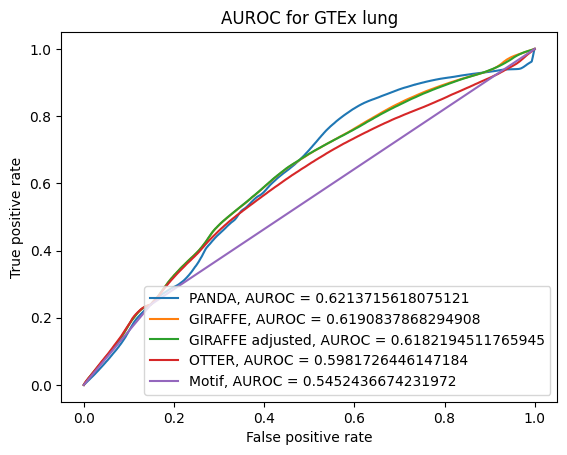

In [10]:
for i in range(len(ground_truths)):
    gt = ground_truths[i].to_numpy()  
    pred = preds[i].to_numpy()
    auc, tpr, fpr = giraffe.utils.evaluate_regulation_auroc(gt, pred)
    plt.plot(fpr, tpr, label=model_names[i] + ", AUROC = " + str(auc))
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("AUROC for GTEx lung")
plt.show()  